In [237]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium
from branca.colormap import LinearColormap
import geodatasets
from shapely import wkt
from shapely.geometry import Point
import os
import imageio
from PIL import Image
from selenium import webdriver
from datetime import datetime
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from webdriver_manager.firefox import GeckoDriverManager
import time
import osmnx as ox
import networkx as nx

ox.config(use_cache=True, log_console=True)  # Cache network data

In [4]:
directory = "C:/Users/Daniel.DESKTOP-2H2HP2R/repos/hamburg_echarging/"

In [5]:
# Funktion zur Uwandlung von xlsx in csv
def convert_xls_to_csv(input_file, output_file, sheet_name=0):
    
    try:
        data = pd.read_excel(input_file, sheet_name=sheet_name)
        data.to_csv(output_file, index=False)
        print(f"Erfolgreich konvertiert: {input_file} -> {output_file}")
    except Exception as e:
        print(f"Fehler: {e}")

In [6]:
# Dateien
input_file = "dtv-dtvw-2004-2023-download-data.xlsx"
output_file = "dtv-dtvw-2004-2023-download-data.csv"

# Ausführen der Funktion
convert_xls_to_csv(input_file, output_file)

Erfolgreich konvertiert: dtv-dtvw-2004-2023-download-data.xlsx -> dtv-dtvw-2004-2023-download-data.csv


In [62]:
# Einladen des deutschlandweiten Ladesäulenregisters und der Hamburger Verkehrsstärke
ladesaeulenregister = pd.read_csv(directory +'Ladesaeulenregister_01122024.csv', header = 0, encoding= 'unicode_escape', delimiter= ';')
verkehrsstaerke = pd.read_csv(directory +'dtv-dtvw-2004-2023-download-data.csv', header = 0, encoding= 'unicode_escape', delimiter= ',')


C:\Users\Daniel.DESKTOP-2H2HP2R\AppData\Local\Temp\ipykernel_6768\3649124898.py:2: DtypeWarning: Columns (29,32) have mixed types. Specify dtype option on import or set low_memory=False.
  ladesaeulenregister = pd.read_csv(directory +'Ladesaeulenregister_01122024.csv', header = 0, encoding= 'unicode_escape', delimiter= ';')


In [14]:
# Informationenabfrag
print(verkehrsstaerke['zaehlstelle'].describe())
print(ladesaeulenregister['Betreiber'].describe())

count    1428.000000
mean     2924.792717
std       901.720521
min      1013.000000
25%      2392.000000
50%      2934.000000
75%      3556.000000
max      7621.000000
Name: zaehlstelle, dtype: float64
count                            80723
unique                           10849
top       EnBW mobility+ AG und Co.KG 
freq                              3972
Name: Betreiber, dtype: object


In [26]:
#Einladen Zaehlstellen CSV-Dateien
bedarfszaehlstellen = pd.read_csv(directory +'verkehrszaehlstellen_csv/app_kfz_bedarfszaehlstellen_EPSG_25832.csv', header = 0, encoding= 'unicode_escape', delimiter= ';')
dauerzaehlstellen = pd.read_csv(directory +'verkehrszaehlstellen_csv/app_kfz_dauerzaehlstellen_EPSG_25832.csv', header = 0, encoding= 'unicode_escape', delimiter= ';')
jahreszaehlstellen = pd.read_csv(directory +'verkehrszaehlstellen_csv/app_kfz_jaehrliche_zaehlstellen_EPSG_25832.csv', header = 0, encoding= 'unicode_escape', delimiter= ';')
pegel = pd.read_csv(directory +'verkehrszaehlstellen_csv/app_kfz_pegel_EPSG_25832.csv', header = 0, encoding= 'unicode_escape', delimiter= ';')

In [69]:
#Zusammenführen der CSV-Dateien
zaehlstellen_all = pd.concat([bedarfszaehlstellen, dauerzaehlstellen, jahreszaehlstellen, pegel], axis=0, ignore_index=True)
print(zaehlstellen_all)
zaehlstellen_all.to_csv("C:/Users/Daniel.DESKTOP-2H2HP2R/repos/hamburg_echarging/zaehlstellen_all.csv", index = False)

                                 ï»¿_fid  zaehlstelle  \
0     APP_KFZ_BEDARFSZAEHLSTELLEN_163670            2   
1     APP_KFZ_BEDARFSZAEHLSTELLEN_163671            3   
2     APP_KFZ_BEDARFSZAEHLSTELLEN_163672            5   
3     APP_KFZ_BEDARFSZAEHLSTELLEN_163673            6   
4     APP_KFZ_BEDARFSZAEHLSTELLEN_163674            7   
...                                  ...          ...   
2364                 APP_KFZ_PEGEL_37376         4088   
2365                 APP_KFZ_PEGEL_37377         4092   
2366                 APP_KFZ_PEGEL_37378         4094   
2367                 APP_KFZ_PEGEL_37379         4098   
2368                 APP_KFZ_PEGEL_37380         4102   

                                   bezeichnung  knoten letzte_zaehlung  \
0        Osdorfer LandstraÃe / WindmÃ¼hlenweg     NaN      01.01.2023   
1                Neue StraÃe / Harburger Ring     NaN      01.01.2023   
2     Elise-Averdieck-StraÃe / Oben Borgfelde     NaN      01.01.2024   
3          Oberhafe

In [102]:
# Zusammenfuehrung der georeferenzierten Zaehlstellen(zaehlstellen_all.csv) mit den Zaehlstaerken(dtv-dtvw-2004-2023-download-data.csv)
georef_verkehr = verkehrsstaerke.merge(
    zaehlstellen_all[['zaehlstelle', 'geom', 'coordinate_reference_system']],
    on='zaehlstelle',
    how='left'  # "left" sorgt dafür, dass alle Zeilen aus verkehrsstaerke erhalten bleiben
)

# Ergebnis speichern
georef_verkehr.to_csv('georef_verkehr.csv', index=False)

# Ergebnis anzeigen (optional)
print(georef_verkehr)

      zaehlstelle  Ebene                                     Bezeichnung  \
0            1013    371                    Krohnstieg NO Garstedter Weg   
1            1013    371                    Krohnstieg NO Garstedter Weg   
2            1013    371                    Krohnstieg NO Garstedter Weg   
3            1013    371                    Krohnstieg NO Garstedter Weg   
4            1017    372                    Garstedter Weg SW Krohnstieg   
...           ...    ...                                             ...   
1423         7459    221                    Hammer StraÃe NW Grenzknick   
1424         7621     96  EulenkrugstraÃe W Im Meienthun (Landesgrenze)   
1425         7621     96  EulenkrugstraÃe W Im Meienthun (Landesgrenze)   
1426         7621     96  EulenkrugstraÃe W Im Meienthun (Landesgrenze)   
1427         7621     96  EulenkrugstraÃe W Im Meienthun (Landesgrenze)   

                  Kategorie   2004   2005   2006   2007   2008   2009  ...  \
0        

In [72]:
# Ausschneiden des Ladesaeulenregisters auf die Stadflaeche Hamburgs und nur Schnellladesaeulen

# Filter anwenden: Nur Zeilen, in denen das Bundesland "Hamburg" ist
hamburg_tabelle = ladesaeulenregister[(ladesaeulenregister['Bundesland'] == 'Hamburg') & (ladesaeulenregister['Art der Ladeeinrichtung'] == 'Schnellladeeinrichtung')]

# Replace commas with dots in the coordinate columns (Latitude and Longitude)
hamburg_tabelle['Laengengrad'] = hamburg_tabelle['Laengengrad'].str.replace(',', '.')
hamburg_tabelle['Breitengrad'] = hamburg_tabelle['Breitengrad'].str.replace(',', '.')

# Replace formatting error
hamburg_tabelle['Betreiber'] = hamburg_tabelle['Betreiber'].str.replace('ï¿½', 'ue')
hamburg_tabelle['Strasse'] = hamburg_tabelle['Strasse'].str.replace('straï¿½e', 'strasse')
hamburg_tabelle['Strasse'] = hamburg_tabelle['Strasse'].str.replace('Straï¿½e', 'Strasse')

# Gefilterte Tabelle speichern
hamburg_tabelle.to_csv('hamburg_tabelle.csv', index=False)

# Gefilterte Tabelle anzeigen (optional)
print(hamburg_tabelle)

                               Betreiber        Anzeigename (Karte)  \
36057     E.ON Drive Infrastructure GmbH  E.ON Drive Infrastructure   
36058     E.ON Drive Infrastructure GmbH  E.ON Drive Infrastructure   
36059     E.ON Drive Infrastructure GmbH  E.ON Drive Infrastructure   
36060     E.ON Drive Infrastructure GmbH  E.ON Drive Infrastructure   
36061     E.ON Drive Infrastructure GmbH  E.ON Drive Infrastructure   
...                                  ...                        ...   
37640             Shell Deutschland GmbH                        NaN   
37641             Shell Deutschland GmbH                        NaN   
37669  Hamburger Energiewerke Mobil GmbH                 HEnW-Mobil   
37670  Hamburger Energiewerke Mobil GmbH                 HEnW-Mobil   
37692                 Comfortcharge GmbH             Comfort Charge   

                 Strasse Hausnummer             Adresszusatz  Postleitzahl  \
36057   Mï¿½nckebergstr.          1  Media Markt, Parkdeck 7       20

C:\Users\Daniel.DESKTOP-2H2HP2R\AppData\Local\Temp\ipykernel_6768\2234794685.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamburg_tabelle['Laengengrad'] = hamburg_tabelle['Laengengrad'].str.replace(',', '.')
C:\Users\Daniel.DESKTOP-2H2HP2R\AppData\Local\Temp\ipykernel_6768\2234794685.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hamburg_tabelle['Breitengrad'] = hamburg_tabelle['Breitengrad'].str.replace(',', '.')
C:\Users\Daniel.DESKTOP-2H2HP2R\AppData\Local\Temp\ipykernel_6768\2234794685.py:11

In [199]:
# Kontrolle
print(hamburg_tabelle['Breitengrad'].describe())

count            330
unique           193
top       53.5716060
freq              12
Name: Breitengrad, dtype: object


In [ ]:
# Kartenerstellung der Ladesaeulen und Verkehrsstaerken: https://geopandas.org/en/stable/gallery/plotting_with_folium.html
# conda install folium -c conda-forge
# conda install geodatasets -c conda-forge

In [100]:
# hamburg_tabelle = 'hamburg_tabelle.csv'

In [101]:
# Create point geometries
geometry = gpd.points_from_xy(hamburg_tabelle.Laengengrad, hamburg_tabelle.Breitengrad)
geo_df = gpd.GeoDataFrame(
    hamburg_tabelle,
    geometry=geometry
)
geo_df.head()

,Betreiber,Anzeigename (Karte),Strasse,Hausnummer,Adresszusatz,Postleitzahl,Ort,Kreis/kreisfreie Stadt,Bundesland,Breitengrad,...,Steckertypen4,P4 [kW],Public Key4,Steckertypen5,P5 [kW],Public Key5,Steckertypen6,P6 [kW],Public Key6,geometry
36057,E.ON Drive Infrastructure GmbH,E.ON Drive Infrastructure,Mï¿½nckebergstr.,1,"Media Markt, Parkdeck 7",20095.0,Hamburg,Kreisfreie Stadt Hamburg,Hamburg,53.550522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.00572 53.55052)
36058,E.ON Drive Infrastructure GmbH,E.ON Drive Infrastructure,Mï¿½nckebergstr.,1,"Media Markt, Parkdeck 7",20095.0,Hamburg,Kreisfreie Stadt Hamburg,Hamburg,53.550522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.00572 53.55052)
36059,E.ON Drive Infrastructure GmbH,E.ON Drive Infrastructure,Mï¿½nckebergstr.,1,"Media Markt, Parkdeck 7",20095.0,Hamburg,Kreisfreie Stadt Hamburg,Hamburg,53.550522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.00572 53.55052)
36060,E.ON Drive Infrastructure GmbH,E.ON Drive Infrastructure,Mï¿½nckebergstr.,1,NaN,20095.0,Hamburg,Kreisfreie Stadt Hamburg,Hamburg,53.550522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.00572 53.55052)
36061,E.ON Drive Infrastructure GmbH,E.ON Drive Infrastructure,Mï¿½nckebergstr.,1,"Media Markt, Parkdeck 7",20095.0,Hamburg,Kreisfreie Stadt Hamburg,Hamburg,53.550522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (10.00572 53.55052)


In [75]:
df1 = pd.read_csv("hamburg_tabelle.csv")
# Keep only relevant columns
df = df1.loc[:, ("Betreiber", "Breitengrad", "Laengengrad")]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Betreiber    330 non-null    object 
 1   Breitengrad  330 non-null    float64
 2   Laengengrad  330 non-null    float64
dtypes: float64(2), object(1)
memory usage: 7.9+ KB


In [76]:
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

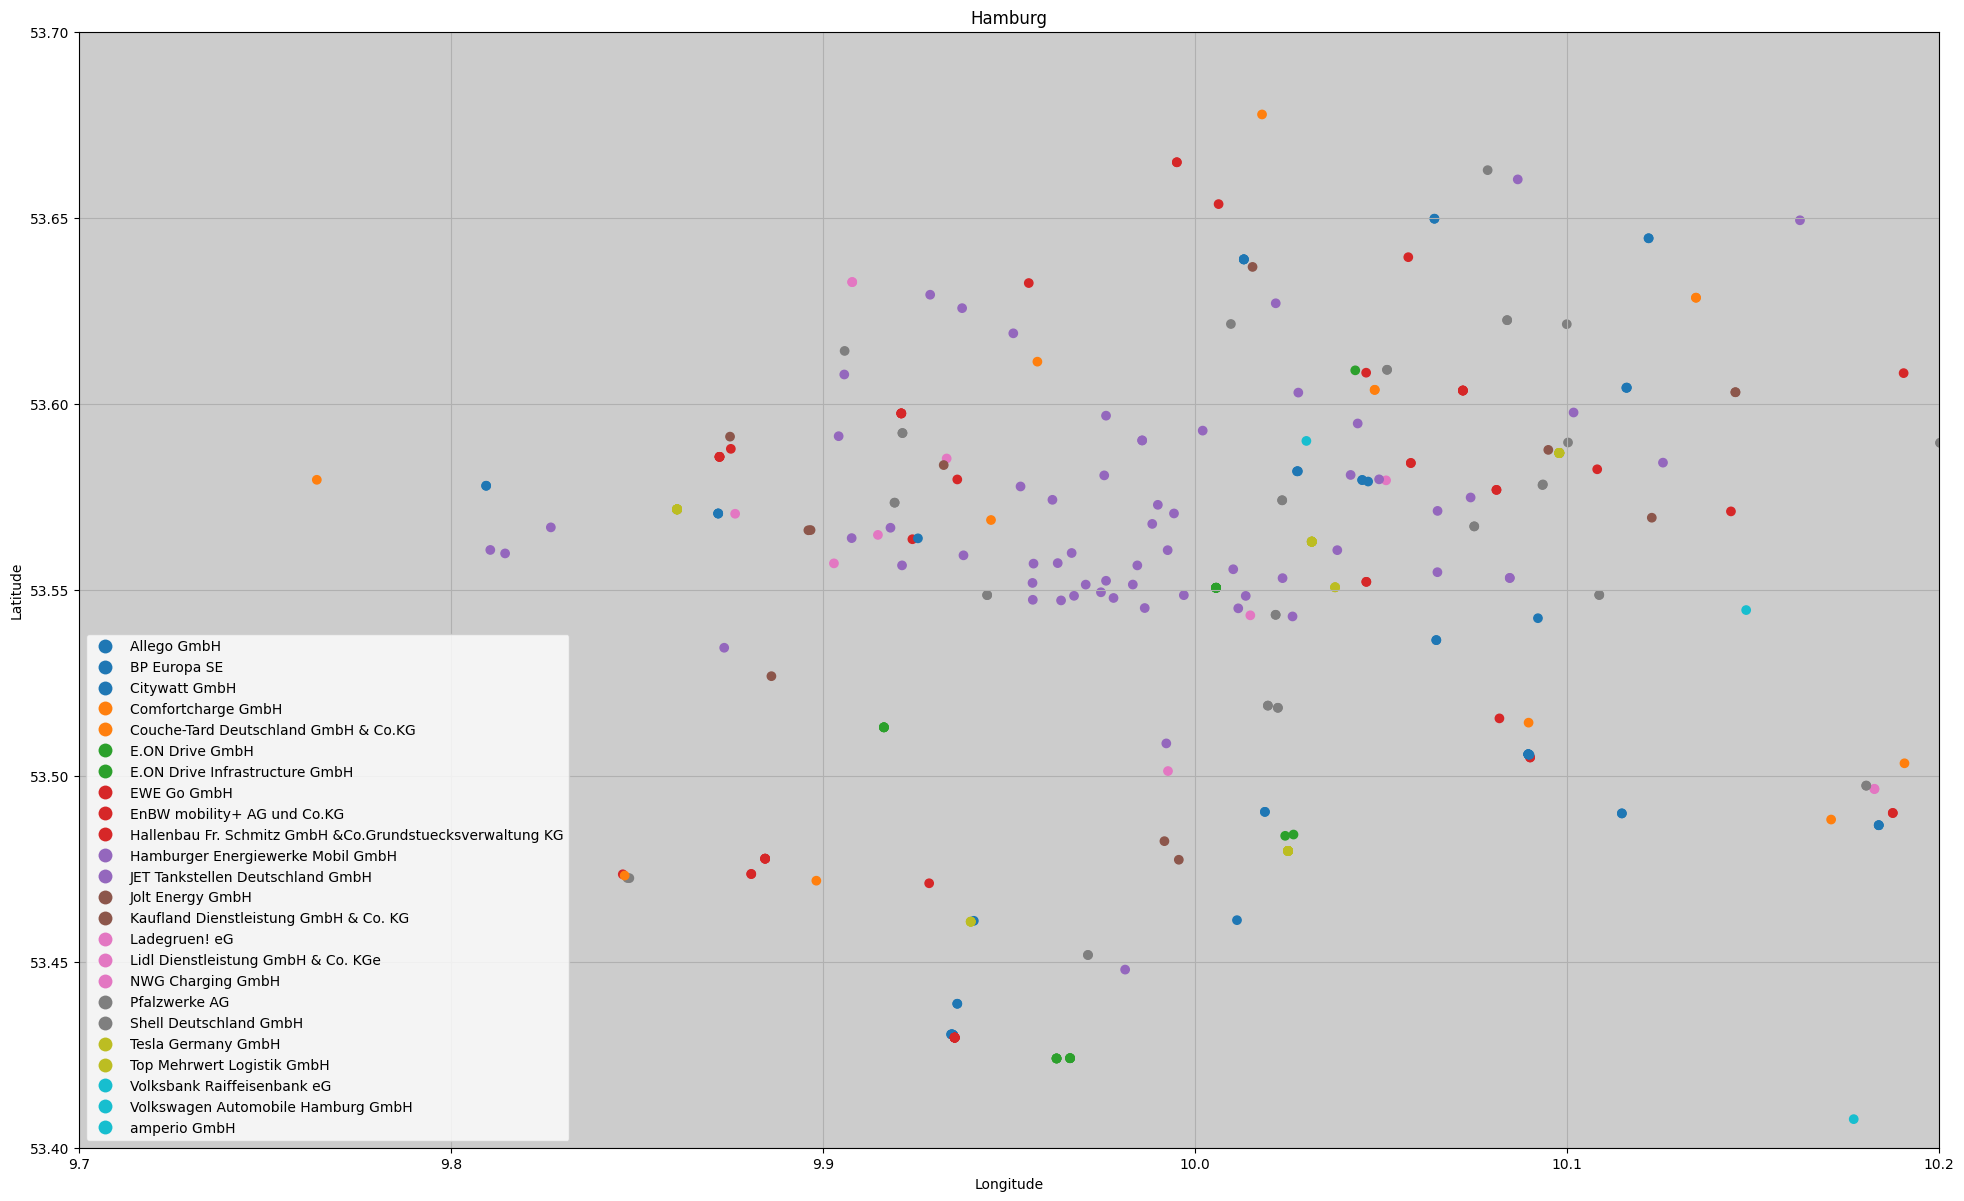

In [77]:
fig, ax = plt.subplots(figsize=(24, 18))
world.plot(ax=ax, alpha=0.4, color="grey")
geo_df.plot(column="Betreiber", ax=ax, legend=True)

# Set title
plt.title("Hamburg")

# Add coordinate labels
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Set zoom level by defining axis limits
# You'll need to determine appropriate values for your area of interest
# Example for Hamburg area (approximate coordinates):
ax.set_xlim(9.7, 10.2)  # Longitude range
ax.set_ylim(53.4, 53.7)  # Latitude range

# Optional: Add grid
ax.grid(True)

In [ ]:
# 1. Prepare the data
betreibers = geo_df["Betreiber"].unique()
n_betreibers = len(betreibers)
print(n_betreibers)

# 2. Generate a color palette (e.g., 'Set3', 'viridis', 'Paired')
colors = LinearColormap(
    colors=["#FF5733",  # kräftiges Orange
    "#33FF57",  # frisches Grün
    "#3357FF",  # kräftiges Blau
    "#FF33A1",  # Pink
    "#A133FF",  # Violett
    "#33FFF5",  # Türkis
    "#FFC300",  # Gelb
    "#FF6F33",  # Hellorange
    "#33FFBD",  # Mintgrün
    "#8D33FF",  # Dunkelviolett
    "#FF3333",  # Rot
    "#33D4FF",  # Himmelblau
    "#C70039",  # Weinrot
    "#900C3F",  # Dunkelrot
    "#DAF7A6",  # Hellgrün
    "#581845",  # Aubergine
    "#1ABC9C",  # Jadegrün
    "#2ECC71",  # Smaragdgrün
    "#3498DB",  # Mittelblau
    "#9B59B6",  # Lila
    "#34495E",  # Dunkelblau/Grau
    "#F39C12",  # Safran
    "#D35400",  # Terracotta
    "#7F8C8D" ],  # Graublau],  # or any palette
    index=range(n_betreibers), 
    vmin=0, 
    vmax=n_betreibers
).to_step(n_betreibers)

# 3. Map each Betreiber to a color
betreiber_color_map = {
    betreiber: colors(i) 
    for i, betreiber in enumerate(betreibers)
}

# 4. Create the map
m = folium.Map(
    location=[geo_df.geometry.centroid.y.mean(), geo_df.geometry.centroid.x.mean()],
    zoom_start=12
)

# 5. Add colored markers (no popup)
for idx, row in geo_df.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,  # Adjust size
        color=betreiber_color_map[row["Betreiber"]],
        fill=True,
        fill_color=betreiber_color_map[row["Betreiber"]],
    ).add_to(m)

# 6. Add a legend
legend = '''
     <div style="position: fixed; 
                 bottom: 50px; right: 50px; width: 300px; height: auto; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white; padding: 10px;">
         <b>Betreiber Legend</b><br>
         {}
     </div>
'''.format(
    '<br>'.join([
        f'<i style="background:{betreiber_color_map[betreiber]}; width: 15px; height: 15px; display: inline-block;"></i> {betreiber}'
        for betreiber in betreibers
    ])
)

m.get_root().html.add_child(folium.Element(legend))

# 7. Save or display
m  # Display in notebook (if using Jupyter)



24


In [106]:
# This example uses heatmaps to visualize the density of volcanoes
# which is more in some parts of the world compared to others.

from folium import plugins

map = folium.Map(location=[53.6503, 9.9728], tiles="Cartodb dark_matter", zoom_start=10)

heat_data = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

heat_data
plugins.HeatMap(heat_data).add_to(map)

map

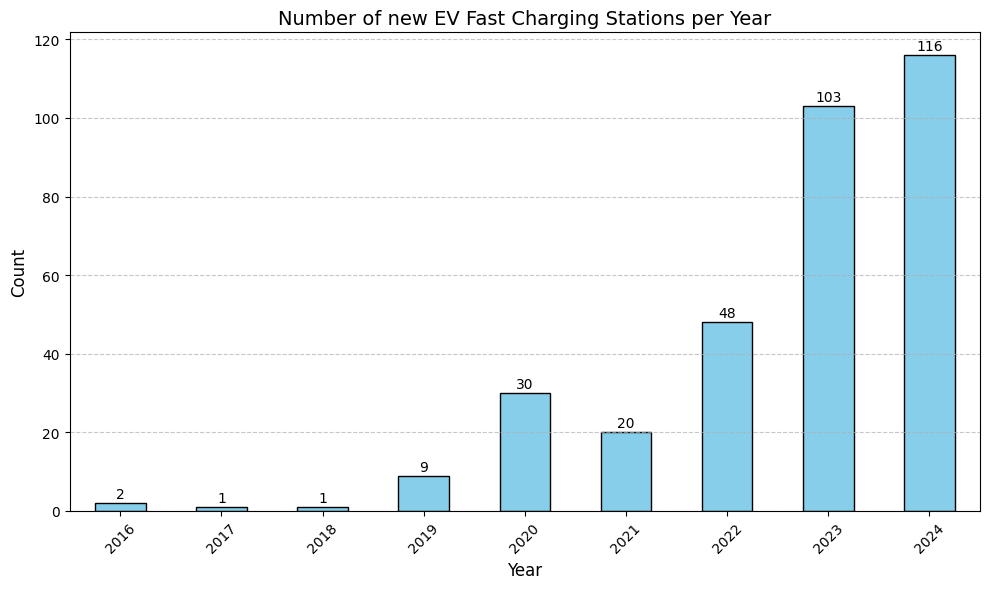

In [93]:
# Load data and extract years
df1 = pd.read_csv("hamburg_tabelle.csv")
years = pd.to_datetime(df1["Inbetriebnahmedatum"], format='%d.%m.%Y', errors='coerce').dt.year
year_counts = years.dropna().value_counts().sort_index()

# Create the plot
plt.figure(figsize=(10, 6))
bars = year_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add exact counts on top of each bar
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-position (center of bar)
        bar.get_height() + 0.5,             # y-position (slightly above bar)
        f'{int(bar.get_height())}',         # text (count value)
        ha='center',                        # horizontal alignment
        va='bottom',                        # vertical alignment
        fontsize=10
    )

# Customize the plot
plt.title("Number of new EV Fast Charging Stations per Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# https://www.kba.de/DE/Statistik/Produktkatalog/produkte/Fahrzeuge/fz13_b_uebersicht.html;jsessionid=3F4CAFEC87BFE643BB7571F6368ECAC7.live11311?nn=4543062
# 2023: 13.186 (E), 4.356 (P)
# 2022: 13078(E), 14481(P)
# 2021: 7334 (E), 8295 (P)
# 2020: 3395(E), 2502(P)
# 2019: 1395 (E), 1227 (P)
# 2018: 1126 (E), 879 (P)
# 2017: 608 (E), 760 (P)
# 2016: 358 (E), - (P)

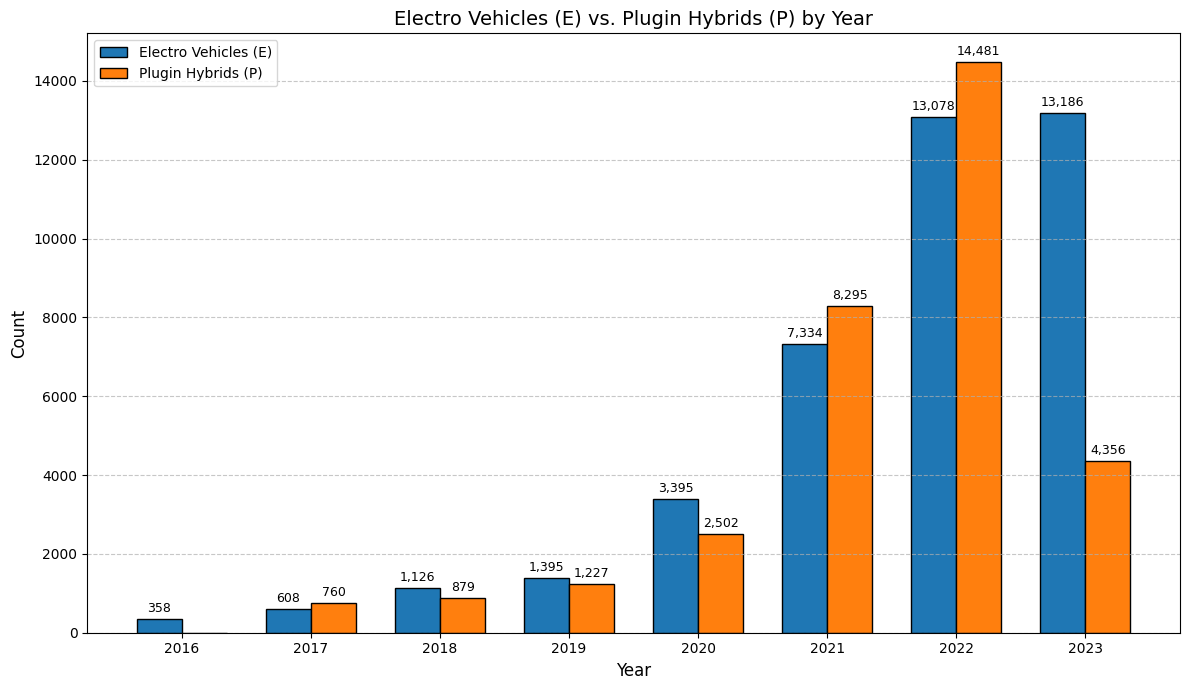

In [94]:
# Data
years = np.array([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])
E = np.array([358, 608, 1126, 1395, 3395, 7334, 13078, 13186])
P = np.array([0, 760, 879, 1227, 2502, 8295, 14481, 4356])  # 2016 P set to 0 (missing)

# Plot
plt.figure(figsize=(12, 7))
width = 0.35  # Bar width

# Create bars
bars_E = plt.bar(years - width/2, E, width, label='Electro Vehicles (E)', color='#1f77b4', edgecolor='black')
bars_P = plt.bar(years + width/2, P, width, label='Plugin Hybrids (P)', color='#ff7f0e', edgecolor='black')

# Add counts on top of bars
for bars in [bars_E, bars_P]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Skip zero (2016 P)
            plt.text(bar.get_x() + bar.get_width()/2, height + 100,
                    f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# Customize
plt.title("Electro Vehicles (E) vs. Plugin Hybrids (P) by Year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(years)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [104]:
print(georef_verkehr.geom)

0       POINT (564489.000000 5944555.000000)
1       POINT (564489.000000 5944555.000000)
2       POINT (564489.000000 5944555.000000)
3       POINT (564489.000000 5944555.000000)
4       POINT (564402.000000 5944460.000000)
                        ...                 
1423    POINT (570825.000000 5935165.000000)
1424    POINT (578726.000000 5944586.000000)
1425    POINT (578726.000000 5944586.000000)
1426    POINT (578726.000000 5944586.000000)
1427    POINT (578726.000000 5944586.000000)
Name: geom, Length: 1428, dtype: object


In [130]:
# Check if geom is a string
print(type(georef_verkehr.geom.iloc[0]))
print(traffic_df.geom)

<class 'str'>
0       POINT (564489.000000 5944555.000000)
1       POINT (564489.000000 5944555.000000)
2       POINT (564489.000000 5944555.000000)
3       POINT (564489.000000 5944555.000000)
4       POINT (564402.000000 5944460.000000)
                        ...                 
1423    POINT (570825.000000 5935165.000000)
1424    POINT (578726.000000 5944586.000000)
1425    POINT (578726.000000 5944586.000000)
1426    POINT (578726.000000 5944586.000000)
1427    POINT (578726.000000 5944586.000000)
Name: geom, Length: 1428, dtype: object


In [202]:
# 1. Read CSV (ensure proper encoding)
df = pd.read_csv("georef_verkehr.csv", encoding='utf-8')  # or 'latin-1' if UTF-8 fails

# 2. Clean the geom column
# Drop rows where geom is NaN or not a string
df = df.dropna(subset=['geom'])
df['geom'] = df['geom'].astype(str)  # Force string type

# 3. Parse WKT safely (skip invalid geometries)
def safe_wkt_load(x):
    try:
        return wkt.loads(x)
    except:
        return None

df['geom'] = df['geom'].apply(safe_wkt_load)

# 4. Drop rows where geometry parsing failed
df = df.dropna(subset=['geom'])

# 5. Create GeoDataFrame
gdf_traffic = gpd.GeoDataFrame(
    df,
    geometry='geom',
    crs="EPSG:25832"  # UTM Zone 32N (adjust if needed)
)

print(gdf_traffic.head())

   zaehlstelle  Ebene                   Bezeichnung              Kategorie  \
0         1013    371  Krohnstieg NO Garstedter Weg          DTV (Kfz/24h)   
1         1013    371  Krohnstieg NO Garstedter Weg         DTVw (Kfz/24h)   
2         1013    371  Krohnstieg NO Garstedter Weg  SV-Anteil am DTVw (%)   
3         1013    371  Krohnstieg NO Garstedter Weg     Baustelleneinfluss   
4         1017    372  Garstedter Weg SW Krohnstieg          DTV (Kfz/24h)   

    2004   2005   2006   2007   2008   2009  ...   2016   2017   2018   2019  \
0  51000  52000  52000  53000  52000  52000  ...  51000  52000  51000  51000   
1  56000  56000  57000  58000  57000  56000  ...  56000  56000  56000  56000   
2      6      6      6      6      6      6  ...      5      4      5      5   
3    NaN    NaN    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN   
4  12000  11000  11000  11000  11000  11000  ...  13000  12000  12000  12000   

    2020   2021   2022   2023                     

In [203]:
# 1. Convert UTM (EPSG:25832) to Lat/Lon (EPSG:4326)
gdf_traffic = gdf_traffic.to_crs("EPSG:4326")  # Reproject to WGS84

# 2. Create Folium map centered on Hamburg
map = folium.Map(location=[53.5506, 9.9937],  # Hamburg coordinates
                 tiles="Cartodb dark_matter", 
                 zoom_start=11)

# 3. Prepare heatmap data as [lat, lon] pairs
heat_data = [[point.y, point.x] for point in gdf_traffic.geometry]  # Note: y=lat, x=lon

# 4. Add HeatMap layer
plugins.HeatMap(heat_data, radius=15, blur=10).add_to(map)  # Adjust radius/blur as needed

# Display the map
map

In [189]:
# GIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIF

# Read the CSV file
df = pd.read_csv('hamburg_tabelle.csv', parse_dates=['Inbetriebnahmedatum'], dayfirst=True)

# Extract year from the date column
df['Year'] = df['Inbetriebnahmedatum'].dt.year

# Get unique years and sort them
unique_years = sorted(df['Year'].unique())

# Create output directory if it doesn't exist
os.makedirs('yearly_maps', exist_ok=True)

# Create a map for each year
for year in unique_years:
    print(f"Processing year {year}...")
    
    # Filter data for the current year
    year_data = df[df['Year'] == year]
    
    # Create a NEW map for each year (don't copy)
    m = folium.Map(
        location=[53.5506, 9.9937], 
        zoom_start=10, 
        tiles="cartodbpositron", 
        attr="CartoDB Positron"
    )
    
    # Add a title to the map (fixed version)
    title_html = '''
        <h3 align="center" style="font-size:16px">
            <b>Charging Stations Operational in {}</b>
        </h3>
    '''.format(year)
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Add markers for each charging station
    for idx, row in year_data.iterrows():
        folium.CircleMarker(
            location=[row['Breitengrad'], row['Laengengrad']],
            radius=3,
            color='blue',
            fill=True,
            fill_color='blue',
            popup=f"{row['Betreiber']}<br>Inbetriebnahmedatum: {row['Inbetriebnahmedatum'].strftime('%d.%m.%Y')}"
        ).add_to(m)
    
    # Save the map as HTML
    m.save(f'yearly_maps/charging_stations_{year}.html')
    
    print(f"Saved map for {year}")

print("All yearly maps created successfully!")

Processing year 2016...
Saved map for 2016
Processing year 2017...
Saved map for 2017
Processing year 2018...
Saved map for 2018
Processing year 2019...
Saved map for 2019
Processing year 2020...
Saved map for 2020
Processing year 2021...
Saved map for 2021
Processing year 2022...
Saved map for 2022
Processing year 2023...
Saved map for 2023
Processing year 2024...
Saved map for 2024
All yearly maps created successfully!


In [190]:
# Set up Firefox options
options = Options()
options.add_argument('--headless')  # Run in background
options.add_argument('--disable-gpu')
options.set_preference('devtools.jsonview.enabled', False)
options.set_preference('general.useragent.override', 'Mozilla/5.0')

# Initialize Firefox WebDriver (auto-downloads GeckoDriver if needed)
driver = webdriver.Firefox(
    service=Service(GeckoDriverManager().install()),
    options=options
)

# Set window size (adjust as needed)
driver.set_window_size(1200, 800)

# Convert each HTML file to PNG
for year in unique_years:
    html_path = f'yearly_maps/charging_stations_{year}.html'
    png_path = f'yearly_maps/charging_stations_{year}.png'
    
    # Open HTML file in Firefox
    driver.get(f'file://{os.path.abspath(html_path)}')
    
    # Wait for map to load
    time.sleep(2)  # Adjust delay if needed
    
    # Take screenshot
    driver.save_screenshot(png_path)
    
    # Crop the image (optional)
    img = Image.open(png_path)
    img = img.crop((0, 0, 1200, 800))  # Adjust crop area
    img.save(png_path)
    
    print(f"Converted {year} to PNG")

driver.quit()
print("All HTML files converted to PNG using Firefox!")

C:\Users\Daniel.DESKTOP-2H2HP2R\AppData\Local\Temp\ipykernel_6768\1154813125.py:10: DeprecationWarning: Firefox will soon stop logging to geckodriver.log by default; Specify desired logs with log_output
  service=Service(GeckoDriverManager().install()),


Converted 2016 to PNG
Converted 2017 to PNG
Converted 2018 to PNG
Converted 2019 to PNG
Converted 2020 to PNG
Converted 2021 to PNG
Converted 2022 to PNG
Converted 2023 to PNG
Converted 2024 to PNG
All HTML files converted to PNG using Firefox!


In [191]:
# List all PNG files sorted by year
png_files = sorted([f for f in os.listdir('yearly_maps') if f.endswith('.png')])

# Open images and convert to RGB (required for GIF)
images = [Image.open(f"yearly_maps/{f}").convert('RGB') for f in png_files]

# Save as GIF (adjust `duration` in milliseconds)
images[0].save(
    'charging_stations_evolution.gif',
    save_all=True,
    append_images=images[1:],
    duration=1000,  # Time per frame (ms)
    loop=0         # 0 = infinite loop
)

In [231]:
# 1. Read CSV (ensure correct encoding)
df = pd.read_csv("georef_verkehr.csv", encoding='utf-8')  # or 'latin-1'

# 2. Filter rows: Keep only "DTV (Kfz/24h)" in 'Kategorie'
df = df[df['Kategorie'] == "DTV (Kfz/24h)"]

# 3. Clean geom column (drop rows where geom is NaN or invalid WKT)
df = df[df['geom'].notna()]
df['geom'] = df['geom'].astype(str)

# 4. Parse WKT safely (skip invalid geometries)
def safe_wkt_load(x):
    try:
        return wkt.loads(x)
    except:
        return None

df['geom'] = df['geom'].apply(safe_wkt_load)
df = df[df['geom'].notna()]

# 5. Create GeoDataFrame (UTM Zone 32N)
gdf_traffic = gpd.GeoDataFrame(
    df,
    geometry='geom',
    crs="EPSG:25832"
)

# 6. Convert to Lat/Lon (WGS84)
gdf_traffic = gdf_traffic.to_crs("EPSG:4326")

# 7. Select a year (e.g., 2023) and ensure counts are numeric
year = "2023"
gdf_traffic[year] = pd.to_numeric(gdf_traffic[year], errors='coerce')  # Convert to float, NaN if invalid
gdf_traffic = gdf_traffic[gdf_traffic[year].notna()]  # Drop NaN counts

# 8. Prepare heatmap data: [lat, lon, weight]
heat_data = [
    [point.y, point.x, float(count)]  # Explicitly convert to float
    for point, count in zip(gdf_traffic.geometry, gdf_traffic[year])
]

# 9. Verify heat_data has no NaNs
assert not any(np.isnan(x[-1]) for x in heat_data), "Heatmap data contains NaNs!"

# 10. Create Folium map (Hamburg)
m = folium.Map(
    location=[53.5506, 9.9937],
    tiles="Cartodb dark_matter", 
    zoom_start=11
)

# 11. Add weighted HeatMap
plugins.HeatMap(
    heat_data,
    radius=15,
    blur=10,
    max_zoom=12,
    min_opacity=0.3,
    # Gradient fix: use string keys or a different approach
    gradient={'0.4': 'blue', '0.6': 'lime', '0.8': 'yellow', '1': 'red'}
).add_to(m)

# 12. Save or display
m

In [232]:
# 1. Prepare the data
betreibers = geo_df["Betreiber"].unique()
n_betreibers = len(betreibers)
print(n_betreibers)

# 2. Generate a color palette
colors = LinearColormap(
    colors=["#FF5733", "#33FF57", "#3357FF", "#FF33A1", "#A133FF", 
            "#33FFF5", "#FFC300", "#FF6F33", "#33FFBD", "#8D33FF",
            "#FF3333", "#33D4FF", "#C70039", "#900C3F", "#DAF7A6",
            "#581845", "#1ABC9C", "#2ECC71", "#3498DB", "#9B59B6",
            "#34495E", "#F39C12", "#D35400", "#7F8C8D"],
    index=range(n_betreibers), 
    vmin=0, 
    vmax=n_betreibers
).to_step(n_betreibers)

# 3. Map each Betreiber to a color
betreiber_color_map = {
    betreiber: colors(i) 
    for i, betreiber in enumerate(betreibers)
}

# 4. Create the base map with dark theme
m = folium.Map(
    location=[geo_df.geometry.centroid.y.mean(), geo_df.geometry.centroid.x.mean()],
    tiles="Cartodb dark_matter",
    zoom_start=12
)

# 11. Add weighted HeatMap
plugins.HeatMap(
    heat_data,
    radius=15,
    blur=10,
    max_zoom=12,
    min_opacity=0.3,
    # Gradient fix: use string keys or a different approach
    gradient={'0.4': 'blue', '0.6': 'lime', '0.8': 'yellow', '1': 'red'}
).add_to(m)

# 6. Add colored markers for charging stations on top
for idx, row in geo_df.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=betreiber_color_map[row["Betreiber"]],
        fill=True,
        fill_color=betreiber_color_map[row["Betreiber"]],
        fill_opacity=0.7  # Slightly transparent to see heatmap underneath
    ).add_to(m)

# 7. Add a combined legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; right: 50px; width: 300px; height: auto; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white; padding: 10px;">
         <b>Map Legend</b><br>
         <p><b>Charging Station Operators:</b></p>
         {}
         <p><b>Heatmap:</b> Traffic density</p>
     </div>
'''.format(
    '<br>'.join([
        f'<i style="background:{betreiber_color_map[betreiber]}; width: 15px; height: 15px; display: inline-block;"></i> {betreiber}'
        for betreiber in betreibers
    ])
)

m.get_root().html.add_child(folium.Element(legend_html))

# 8. Display the map
m

24


In [234]:
# 1. Read and prepare data
df = pd.read_csv('georef_verkehr.csv', encoding='utf-8')

# Filter for "DTV (Kfz/24h)" if needed
df = df[df['Kategorie'] == "DTV (Kfz/24h)"]

# 2. Clean geometry and convert to lat/lon
def safe_wkt_load(x):
    try:
        return wkt.loads(x)
    except:
        return None

df['geom'] = df['geom'].astype(str).apply(safe_wkt_load)
gdf = gpd.GeoDataFrame(df.dropna(subset=['geom']), geometry='geom', crs="EPSG:25832")
gdf = gdf.to_crs("EPSG:4326")

# 3. Create yearly heatmaps (2016-2023)
os.makedirs('yearly_traffic_maps', exist_ok=True)

for year in range(2016, 2024):
    year_col = str(year)
    print(f"Processing {year_col}...")
    
    # Filter valid data points
    year_data = gdf[gdf[year_col].notna()]
    year_data[year_col] = pd.to_numeric(year_data[year_col], errors='coerce')
    year_data = year_data[year_data[year_col] > 0]  # Remove zeros
    
    # Create heatmap data [lat, lon, weight]
    heat_data = [[point.y, point.x, count] 
                for point, count in zip(year_data.geometry, year_data[year_col])]
    
    # Create map
    m = folium.Map(location=[53.5506, 9.9937], 
                  tiles="Cartodb dark_matter", 
                  zoom_start=11)
    
    # Add title
    title_html = f'''
        <h3 align="center" style="font-size:16px">
            <b>Traffic Volume (Kfz/24h) in {year_col}</b>
        </h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Add heatmap (with safe gradient)
    plugins.HeatMap(
        heat_data,
        radius=15,
        blur=10,
        min_opacity=0.3,
        gradient={'0.1': 'blue', '0.3': 'cyan', '0.5': 'lime', '0.7': 'yellow', '1': 'red'}
    ).add_to(m)
    
    # Save
    m.save(f'yearly_traffic_maps/traffic_{year_col}.html')

print("All yearly traffic maps created!")

Processing 2016...
Processing 2017...
Processing 2018...
Processing 2019...
Processing 2020...
Processing 2021...
Processing 2022...
Processing 2023...
All yearly traffic maps created!


c:\Users\Daniel.DESKTOP-2H2HP2R\miniforge3\envs\GIS1\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [235]:
# Set up Firefox options
options = Options()
options.add_argument('--headless')  # Run in background
options.add_argument('--disable-gpu')
options.set_preference('devtools.jsonview.enabled', False)
options.set_preference('general.useragent.override', 'Mozilla/5.0')

# Initialize Firefox WebDriver (auto-downloads GeckoDriver if needed)
driver = webdriver.Firefox(
    service=Service(GeckoDriverManager().install()),
    options=options
)

# Set window size (adjust as needed)
driver.set_window_size(1200, 800)

# Convert each HTML file to PNG
for year in unique_years:
    html_path = f'yearly_traffic_maps/traffic_{year}.html'
    png_path = f'yearly_traffic_maps/traffic_{year}.png'
    
    # Open HTML file in Firefox
    driver.get(f'file://{os.path.abspath(html_path)}')
    
    # Wait for map to load
    time.sleep(2)  # Adjust delay if needed
    
    # Take screenshot
    driver.save_screenshot(png_path)
    
    # Crop the image (optional)
    img = Image.open(png_path)
    img = img.crop((0, 0, 1200, 800))  # Adjust crop area
    img.save(png_path)
    
    print(f"Converted {year} to PNG")

driver.quit()
print("All HTML files converted to PNG using Firefox!")

C:\Users\Daniel.DESKTOP-2H2HP2R\AppData\Local\Temp\ipykernel_6768\2951798524.py:10: DeprecationWarning: Firefox will soon stop logging to geckodriver.log by default; Specify desired logs with log_output
  service=Service(GeckoDriverManager().install()),


Converted 2016 to PNG
Converted 2017 to PNG
Converted 2018 to PNG
Converted 2019 to PNG
Converted 2020 to PNG
Converted 2021 to PNG
Converted 2022 to PNG
Converted 2023 to PNG


WebDriverException: Message: Reached error page: about:neterror?e=fileNotFound&u=file%3A///c%3A/Users/Daniel.DESKTOP-2H2HP2R/repos/hamburg_echarging/yearly_traffic_maps/traffic_2024.html&c=UTF-8&d=Die%20Dateien%20unter%20/c%3A/Users/Daniel.DESKTOP-2H2HP2R/repos/hamburg_echarging/yearly_traffic_maps/traffic_2024.html%20konnten%20nicht%20gefunden%20werden.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:197:5
UnknownError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:869:5
checkReadyState@chrome://remote/content/marionette/navigate.sys.mjs:58:24
onNavigation@chrome://remote/content/marionette/navigate.sys.mjs:347:39
emit@resource://gre/modules/EventEmitter.sys.mjs:148:20
receiveMessage@chrome://remote/content/marionette/actors/MarionetteEventsParent.sys.mjs:33:25


In [236]:
# List all PNG files sorted by year
png_files = sorted([f for f in os.listdir('yearly_traffic_maps') if f.endswith('.png')])

# Open images and convert to RGB (required for GIF)
images = [Image.open(f"yearly_traffic_maps/{f}").convert('RGB') for f in png_files]

# Save as GIF (adjust `duration` in milliseconds)
images[0].save(
    'traffic_evolution.gif',
    save_all=True,
    append_images=images[1:],
    duration=1000,  # Time per frame (ms)
    loop=0         # 0 = infinite loop
)

## OSMNX AND NETWORKX

In [241]:
place_name = "Hamburg"

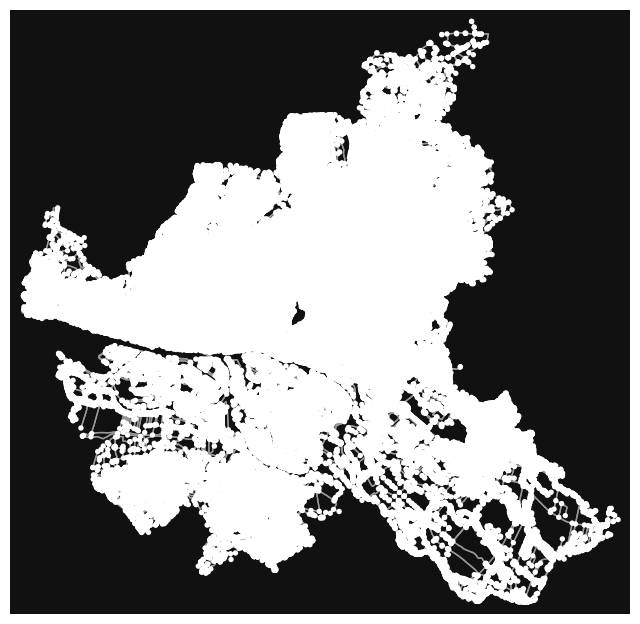

In [242]:
# Set a variable for plotting the graph and get the type of graph.
graph = ox.graph_from_place(place_name)
#type(graph)
fig, ax = ox.plot_graph(graph)

In [ ]:
# Load EV charging stations (replace with your data)
ev_chargers = gpd.read_file("ev_charging_points.geojson")  
ev_chargers = ev_chargers.to_crs(epsg=4326)

# Load traffic points (from earlier)
traffic_data = gpd.read_file("georef_verkehr.geojson")  
traffic_data = traffic_data.to_crs(epsg=4326)

In [243]:
hamburg_network = ox.graph_from_place(
    "Hamburg, Germany", 
    network_type="drive",  # "drive", "walk", "bike"
    simplify=True
)

In [244]:
# Get nearest network node for each EV charger
ev_nodes = []
for geom in geo_df.geometry:
    nearest_node = ox.distance.nearest_nodes(
        hamburg_network, 
        geom.x, 
        geom.y
    )
    ev_nodes.append(nearest_node)

# Get nearest nodes for traffic sensors
traffic_nodes = []
for geom in gdf_traffic.geometry:
    nearest_node = ox.distance.nearest_nodes(
        hamburg_network, 
        geom.x, 
        geom.y
    )
    traffic_nodes.append(nearest_node)

In [245]:
# Add edge travel times (assuming speed=50 km/h)
hamburg_network = ox.add_edge_speeds(hamburg_network)
hamburg_network = ox.add_edge_travel_times(hamburg_network)

# Compute shortest paths
reachability = {}
for traffic_node in traffic_nodes:
    distances = nx.single_source_dijkstra_path_length(
        hamburg_network, 
        traffic_node, 
        weight="travel_time"
    )
    # Find nearest EV charger
    min_distance = float('inf')
    nearest_ev = None
    for ev_node in ev_nodes:
        if distances.get(ev_node, float('inf')) < min_distance:
            min_distance = distances[ev_node]
            nearest_ev = ev_node
    reachability[traffic_node] = {
        "nearest_ev": nearest_ev,
        "travel_time": min_distance
    }

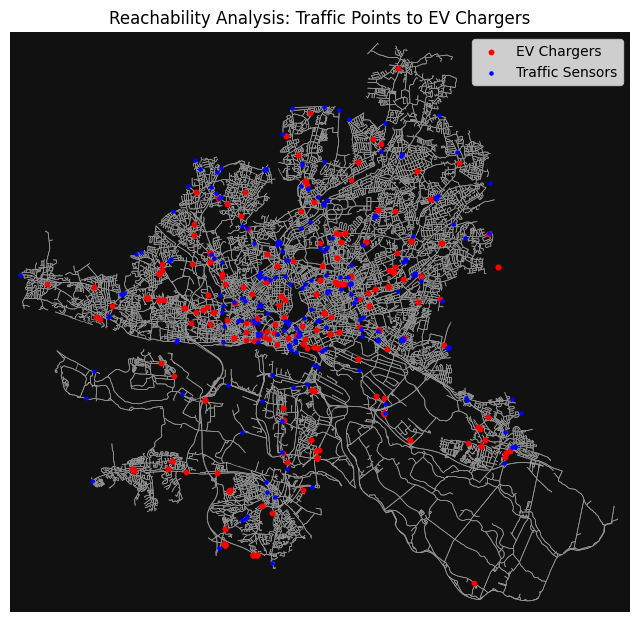

In [246]:
# Plot network with critical points
fig, ax = ox.plot_graph(
    hamburg_network, 
    node_size=0, 
    edge_linewidth=0.5,
    show=False, 
    close=False
)

# Add EV chargers (red) and traffic points (blue)
geo_df.plot(ax=ax, color="red", markersize=10, label="EV Chargers")
gdf_traffic.plot(ax=ax, color="blue", markersize=5, label="Traffic Sensors")

plt.legend()
plt.title("Reachability Analysis: Traffic Points to EV Chargers")
plt.show()

In [249]:
print(gdf_traffic['2023'].unique())

# Input data
traffic_data = gdf_traffic['2023'].unique()

# Compute statistics
min_val = np.min(traffic_data)
max_val = np.max(traffic_data)
mean_val = np.mean(traffic_data)
median_val = np.median(traffic_data)
q1 = np.percentile(traffic_data, 25)
q3 = np.percentile(traffic_data, 75)

# Print key stats
print("=== Key Statistics ===")
print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Mean: {mean_val:.0f}")
print(f"Median: {median_val:.0f}")
print(f"Q1 (25th percentile): {q1:.0f}")
print(f"Q3 (75th percentile): {q3:.0f}\n")

# Define thresholds (using intuitive ranges)
low_threshold = 20000
high_threshold = 50000

# Categorize traffic
def categorize_traffic(value):
    if value <= low_threshold:
        return "Low"
    elif value <= high_threshold:
        return "Medium"
    else:
        return "High"

# Apply categorization
categorized_data = [(value, categorize_traffic(value)) for value in traffic_data]

# Print results
print("=== Categorized Traffic ===")
for value, category in categorized_data:
    print(f"{value:6} → {category}")

# Count values in each category
from collections import Counter
category_counts = Counter(category for _, category in categorized_data)

print("\n=== Counts per Category ===")
for category, count in category_counts.items():
    print(f"{category}: {count} values")

[ 48000.   9000.  42000.  46000.  21000.  25000.  39000.  33000.  32000.
  51000.  15000.  29000. 112000.  14000.   5000.   8000.  11000.   6000.
  20000.  30000.  50000.  18000.  10000.  52000.  12000.  13000.  22000.
  16000.  28000.  26000.  17000.  34000.  31000.  27000.   7000.  23000.
  24000.  38000.   3000.  37000.  64000.  44000.  53000.  35000.  54000.
  19000.  60000.  40000.  47000.]
=== Key Statistics ===
Min: 3000.0
Max: 112000.0
Mean: 30612
Median: 28000
Q1 (25th percentile): 16000
Q3 (75th percentile): 42000

=== Categorized Traffic ===
48000.0 → Medium
9000.0 → Low
42000.0 → Medium
46000.0 → Medium
21000.0 → Medium
25000.0 → Medium
39000.0 → Medium
33000.0 → Medium
32000.0 → Medium
51000.0 → High
15000.0 → Low
29000.0 → Medium
112000.0 → High
14000.0 → Low
5000.0 → Low
8000.0 → Low
11000.0 → Low
6000.0 → Low
20000.0 → Low
30000.0 → Medium
50000.0 → Medium
18000.0 → Low
10000.0 → Low
52000.0 → High
12000.0 → Low
13000.0 → Low
22000.0 → Medium
16000.0 → Low
28000.0 → Med